# Deep Learning with Fashion-MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. <br>

This dataset is taken from <url>https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion</url>

In [38]:
# import necessary library
# TODO: how to make a requirement text file for this kind of stuff

import pandas as pd
import numpy as np
import tensorflow
import cv2
import matplotlib.pyplot as plt         
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline 



In [2]:
#for deep learning
from keras.preprocessing import image  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
import numpy as np
from keras.initializers import VarianceScaling
from glob import glob

Using TensorFlow backend.


In [3]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

print('Training set size: {}'.format(X_train.shape))
print('Testing set size: {}'.format(X_test.shape))


Training set size: (60000, 784)
Testing set size: (10000, 784)


In [4]:
# get valid sets


X_valid = X_train[50000:]
y_valid = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
print("size of training set: {}".format(X_train.shape))
print("size of valid set: {}".format(X_valid.shape))
print("size of test set: {}".format(X_test.shape))

size of training set: (50000, 784)
size of valid set: (10000, 784)
size of test set: (10000, 784)


In [5]:
labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}

In [6]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(28,28)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()
 

#### Output the first 20 images from test set with labels

Ankle boot


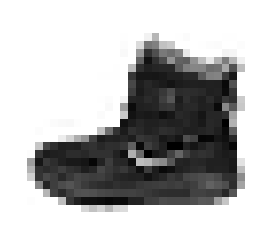

T-shirt/top


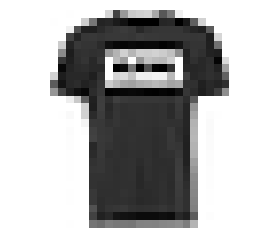

T-shirt/top


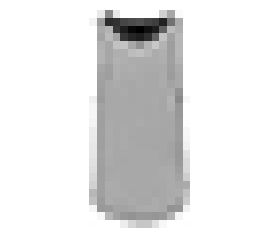

Dress


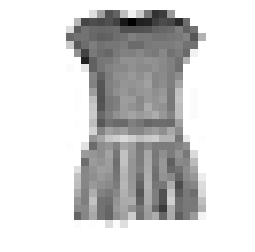

T-shirt/top


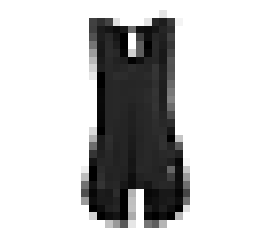

Pullover


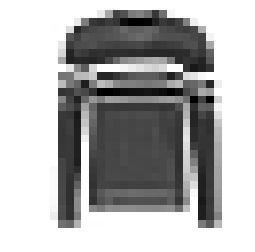

Sneaker


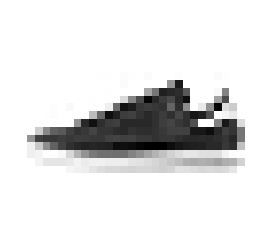

Pullover


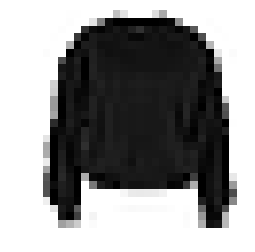

Sandal


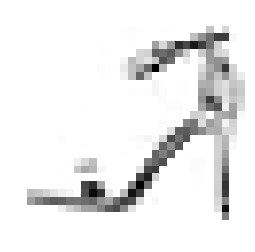

Sandal


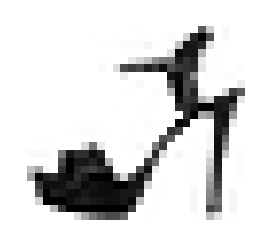

T-shirt/top


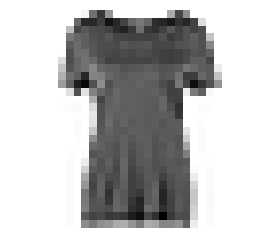

Ankle boot


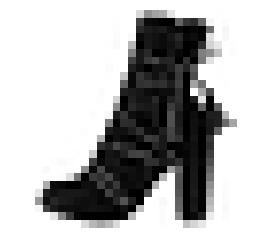

Sandal


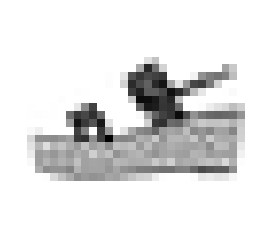

Sandal


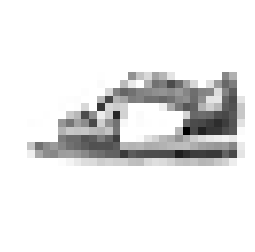

Sneaker


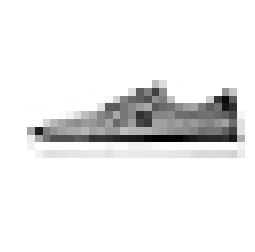

Ankle boot


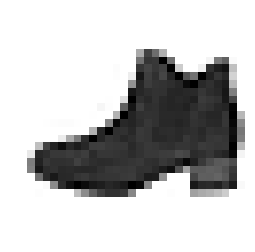

Trouser


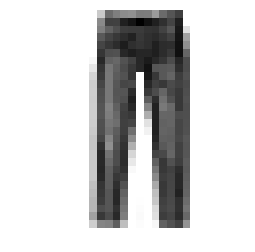

T-shirt/top


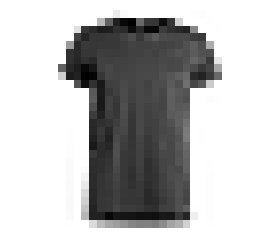

Shirt


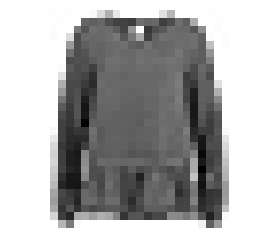

Coat


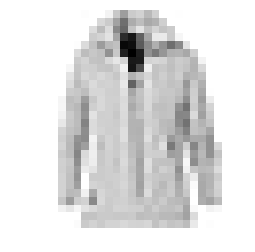

In [7]:
#output the first few 

for i in range(20):
    # output image  
    print(labels[y_train[i]]) 
    display(X_train[i])
    

## Preprocessing

One-hot encode labels; normalize and rescale images

In [7]:
# onehot labels
def one_hot(y):
    return np_utils.to_categorical(np.array(y),10)
y_train = one_hot(y_train)
y_valid = one_hot(y_valid)
y_test = one_hot(y_test)
print(y_train.shape)

(50000, 10)


In [8]:
# reshape image from (?,784) to (?,28,28,1)
def reshape_img(x):
#     x = x/255
    return x.reshape(x.shape[0],28,28,1)
X_train = reshape_img(X_train)
X_valid = reshape_img(X_valid)
X_test = reshape_img(X_test)
# print(X_train[0])


## Data Augmentation

Since the dataset is similar to MNIST, which has normalized orientation and are centered, there is no need to apply data augmentation in this project

However, applying augmentation to dta might be helpful when we apply the model from real photographs where objects may have different orientations 



In [9]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

In [33]:
# try data augmentation
# keras.preprocessing.image.ImageDataGenerator

# data augmentation does not help much
from keras.preprocessing.image import ImageDataGenerator
def get_augmented_generator():
    return ImageDataGenerator(
        featurewise_center=True, \
          featurewise_std_normalization=True,\
         vertical_flip=True,\
         width_shift_range=0.1,height_shift_range=0.1,\
        rotation_range=90
    )

datagen_train = get_augmented_generator()

datagen_train.fit(X_train)


A quick look of how images look like after augmentation

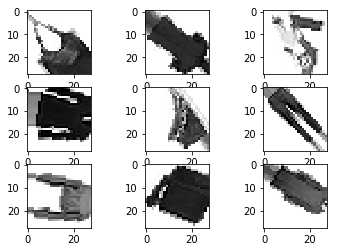

In [34]:

for X_batch, y_batch in datagen_train.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=cm.binary)
    # show the plot
    plt.show()
    break


In [10]:
# Rescale images
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

## Build a DL network

### Lenet-5 Network

Lenet network contains 2 convolutional layers (with max pool), 1 fully connected (dense) layer and 1 output layer. Droupout is applied at the dense layer


Trying multiple optimizer (sgd, adam, adagrad ...) and different initializers and adding batch normalization.

In [33]:
model = Sequential()
pool_size=2

def get_initializer():
    return VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=1)

model.add(Conv2D(filters=32,kernel_size=5,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=5,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(1024,activation='relu',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
__________

In [34]:
# from keras.optimizers import SGD

model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 15
batch_size = 100


checkpointer = ModelCheckpoint(filepath='saved_models/temporary.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s - loss: 0.7323 - acc: 0.8475 - val_loss: 0.3178 - val_acc: 0.8797
Epoch 2/15
50000/50000 [==============================] - 7s - loss: 0.2453 - acc: 0.9102 - val_loss: 0.2501 - val_acc: 0.9083
Epoch 3/15
50000/50000 [==============================] - 7s - loss: 0.1951 - acc: 0.9280 - val_loss: 0.2306 - val_acc: 0.9131
Epoch 4/15
50000/50000 [==============================] - 7s - loss: 0.1611 - acc: 0.9410 - val_loss: 0.2332 - val_acc: 0.9136
Epoch 5/15
50000/50000 [==============================] - 7s - loss: 0.1327 - acc: 0.9514 - val_loss: 0.2202 - val_acc: 0.9188
Epoch 6/15
50000/50000 [==============================] - 7s - loss: 0.1058 - acc: 0.9624 - val_loss: 0.2239 - val_acc: 0.9196
Epoch 7/15
50000/50000 [==============================] - 8s - loss: 0.0847 - acc: 0.9724 - val_loss: 0.2289 - val_acc: 0.9218
Epoch 8/15
50000/50000 [==============================] - 7s 

In [17]:
# load models and test accuracy
def test_accuracy(filepath):
    model.load_weights(filepath)
    score = model.evaluate(X_test,y_test,verbose=1)

    print('----')
    print(score)
    print('\n', 'Test accuracy:', score[1])
def plot_learning_curve(history,graph_name):
    # summarize history for accuracy
    plt.ylim((0.80,1.00))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(graph_name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('learning_curve/' + graph_name + '.png')
    plt.show()
    

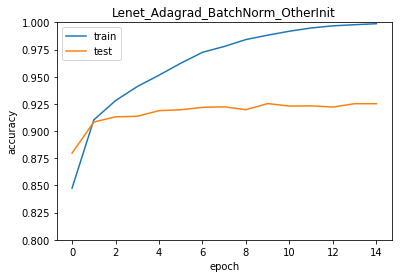

In [35]:
plot_learning_curve(history,'Lenet_Adagrad_BatchNorm_OtherInit')

In [36]:
test_accuracy('saved_models/temporary.hdf5')

 9728/10000 [============================>.] - ETA: 0s----
[0.23284639391899109, 0.91749999999999998]

 Test accuracy: 0.9175


0.9157 adam

0.9139 adam weight

0.9004 adam everything

0.9169 adagrad everything

0.9184 adagrad

0.9192 adagrad everything with truncated normal weight init

Overall, Lenet results in an accuracy between 0.87 and 0.92 on test set. And for all optimizers, performing batch normalization helps training set converge more quickly. Weights are initialized with a truncated normal distribution and are capable of adapting its scale to weights' shape (Variance Scaling). Validation set converges only after 4 or 5 epochs. Adagrad optimizer proves to be a bit better than other optimizer (0.9192 accuracy on training set).    

In [41]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model):
    _, y_test_org = mnist_reader.load_mnist('data/fashion', kind='t10k')
    y_hat = model.predict_classes(X_test)
    cm = confusion_matrix(y_test_org,y_hat)

    labels= ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    sns.heatmap(cm, cmap='Blues',xticklabels=labels, yticklabels=labels,annot=True,fmt=".0f")
    plt.ylabel('True classes')
    plt.xlabel('Predicted classes')

 9312/10000 [==========================>...] - ETA: 0s

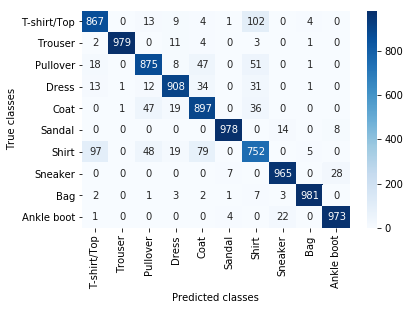

In [42]:
plot_confusion_matrix(model)

The model has a hard time in differentiate shirt-like categories (shirt vs t-shirt/top, shirt vs pullover, coat vs pullover). This is reasonable; as you can see in the plot below, a 28x28 image of a dark color shirt might not show the shirt button clearly and can be mistaken as a t-shirt. Small image size + gray image scale may contribute to these misclassifications

In [55]:
# def first_25_imgs(class_label):
#     _,y_test_org = mnist_reader.load_mnist('data/fashion', kind='t10k')
#     label_set = [im for im in zip(X_test,y_test_org) if im[1] == class_label]
#     plt.figure(figsize=(5, 5))
#     for ind, val in enumerate(label_set[:25]):
#         plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
#         plt.subplot(5, 5, ind + 1)
#         im = 1 - val[0].reshape((28,28))
#         plt.axis("off")
#         plt.text(0, 0, labels[val[1]], fontsize=8, color='blue')
#         plt.imshow(im, cmap='gray')

In [58]:
def plot_misclassifactions(model,predicted_label,true_label):
    _, y_test_org = mnist_reader.load_mnist('data/fashion', kind='t10k')

    y_hat = model.predict_classes(X_test)
    test_wrong = [im for im in zip(X_test,y_hat,y_test_org) if im[2] == true_label and im[1] == predicted_label]

    plt.figure(figsize=(10, 10))
    for ind, val in enumerate(test_wrong[:100]):
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(10, 10, ind + 1)
        im = 1 - val[0].reshape((28,28))
        plt.axis("off")
        plt.text(0, 0, labels[val[2]], fontsize=8, color='blue')
        plt.text(0, 3, labels[val[1]], fontsize=8, color='red')
        plt.imshow(im, cmap='gray')

Get the first 100 images with predicted label = 'Shirt' (6) and true label = 'T-shirt/top' (0)

 9376/10000 [===========================>..] - ETA: 0s

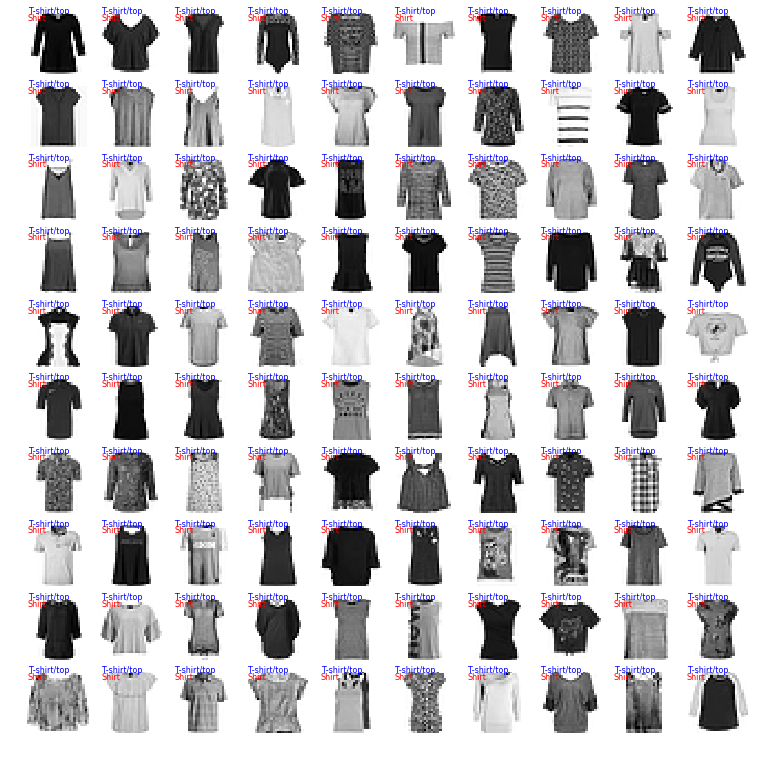

In [59]:
plot_misclassifactions(model,6,0)

Get the first 100 images with predicted label = 'T-shirt/top' (0) and true label = 'Shirt' (6)

 9824/10000 [============================>.] - ETA: 0s

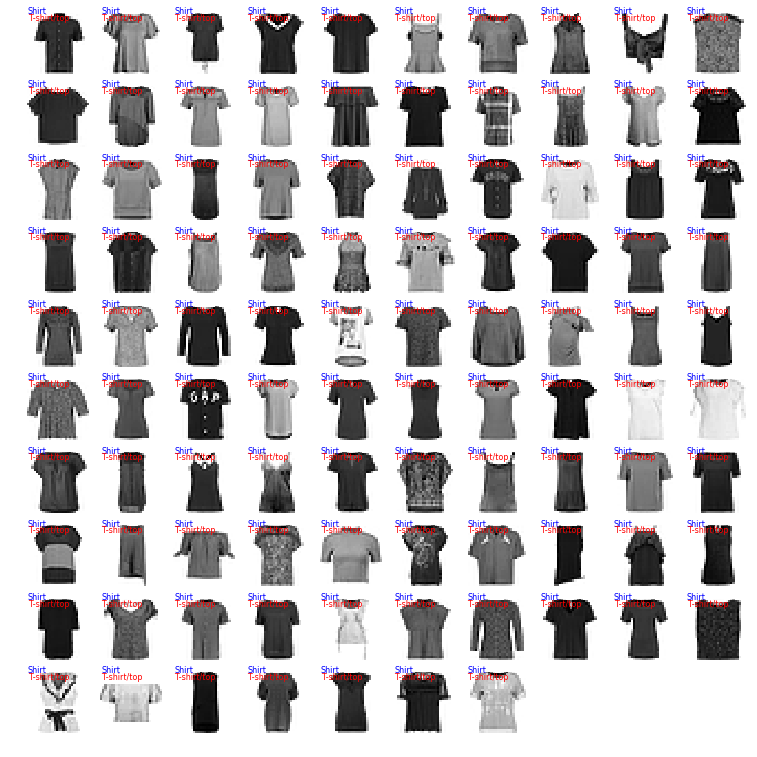

In [60]:
plot_misclassifactions(model,0,6)

In [ ]:
_, y_test_org = mnist_reader.load_mnist('data/fashion', kind='t10k')

y_hat = model.predict_classes(X_test)
test_wrong = [im for im in zip(X_test,y_hat,y_test) if im[1] != im[2] and im[1] == ]

plt.figure(figsize=(10, 10))
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, 0, labels[val[2]], fontsize=8, color='blue')
    plt.text(0, 3, labels[val[1]], fontsize=8, color='red')
    plt.imshow(im, cmap='gray')

## A more complex algorithm

A simpler version of VGGNet (<url>http://www.robots.ox.ac.uk/~vgg/research/very_deep/</url>) is used. Applying a complex architectures to this dataset might be an overkill, but we will see what it can do

In [94]:
from keras.layers.advanced_activations import LeakyReLU
model = Sequential()
pool_size=2
kernel_size=3

def get_initializer():
    return VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=1)
alpha=0.3
#P1
model.add(Conv2D(filters=64,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 input_shape=(28,28,1)))
# model.add(LeakyReLU(alpha=alpha))

model.add(Conv2D(filters=64,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling2D(pool_size=pool_size))

#P2
model.add(Conv2D(filters=128,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(Conv2D(filters=128,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling2D(pool_size=pool_size))

#P3
model.add(Conv2D(filters=256,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(Conv2D(filters=256,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(Conv2D(filters=256,kernel_size=kernel_size,padding='same',\
                 activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
# model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling2D(pool_size=pool_size))

#P4
model.add(Conv2D(filters=512,kernel_size=kernel_size,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
model.add(Conv2D(filters=512,kernel_size=kernel_size,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
model.add(Conv2D(filters=512,kernel_size=kernel_size,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(2048,\
                activation='relu',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
# model.add(LeakyReLU(alpha=alpha))
model.add(Dropout(0.3))

model.add(Dense(2048,\
                activation='relu',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
# model.add(LeakyReLU(alpha=alpha))
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_151 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 7, 7, 256)         295168    
__________

In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 15
batch_size = 100


checkpointer = ModelCheckpoint(filepath='saved_models/simple3.vgg.adam.relu.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 43s - loss: 0.8916 - acc: 0.6564 - val_loss: 0.4510 - val_acc: 0.8449
Epoch 2/30
50000/50000 [==============================] - 41s - loss: 0.3872 - acc: 0.8605 - val_loss: 0.3446 - val_acc: 0.8775
Epoch 3/30
50000/50000 [==============================] - 40s - loss: 0.3209 - acc: 0.8856 - val_loss: 0.3482 - val_acc: 0.8769
Epoch 4/30
50000/50000 [==============================] - 40s - loss: 0.2840 - acc: 0.8981 - val_loss: 0.3143 - val_acc: 0.8866
Epoch 5/30
50000/50000 [==============================] - 40s - loss: 0.2681 - acc: 0.9038 - val_loss: 0.3408 - val_acc: 0.8693
Epoch 6/30
50000/50000 [==============================] - 41s - loss: 0.2463 - acc: 0.9128 - val_loss: 0.3002 - val_acc: 0.8963
Epoch 7/30
50000/50000 [==============================] - 40s - loss: 0.2270 - acc: 0.9182 - val_loss: 0.2805 - val_acc: 0.9024
Epoch 8/30
50000/50000 [==============================

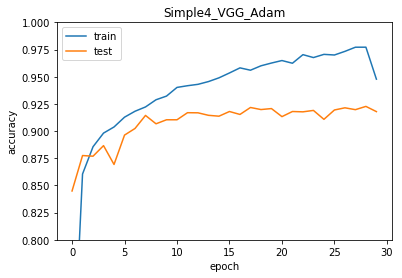

 9920/10000 [============================>.] - ETA: 0s----
[0.26637553538680075, 0.91310000000000002]

 Test accuracy: 0.9131


In [96]:
# plt.ylim((0.80,1.00))
plot_learning_curve(history,'Simple3_VGG_Adam')


In [97]:
test_accuracy('saved_models/simple3.vgg.adam.relu.hdf5')

 9856/10000 [============================>.] - ETA: 0s----
[0.26426467147171495, 0.91800000000000004]

 Test accuracy: 0.918


Test acccuracy on VGGNet is similar to Lecun net, which confirms my thought on how a complex model might not work well on this simple dataset.

# Simplest model with similar accuracy

In [119]:
model = Sequential()
pool_size=2
kernel_size=3
def get_initializer():
    return VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=1)

model.add(Conv2D(filters=64,kernel_size=kernel_size,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(BatchNormalization())

model.add(Conv2D(filters=128,kernel_size=kernel_size,padding='same',activation='relu',\
                 kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
                 ))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128,kernel_size=kernel_size,padding='same',activation='relu',\
#                  kernel_initializer=get_initializer(),\
#                  bias_initializer = get_initializer(),\
#                  ))
# model.add(MaxPooling2D(pool_size=pool_size))

# model.add(Conv2D(filters=256,kernel_size=kernel_size,padding='same',activation='relu',\
#                  kernel_initializer=get_initializer(),\
#                  bias_initializer = get_initializer(),\
#                  ))
# model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())


model.add(Dense(10,activation='softmax',\
               kernel_initializer=get_initializer(),\
                 bias_initializer = get_initializer(),\
               ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 10)                62730     
Total params: 137,226
Trainable params: 137,226
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 15
batch_size = 100


checkpointer = ModelCheckpoint(filepath='saved_models/scratch.2fc.adam.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s - loss: 0.4691 - acc: 0.8350 - val_loss: 0.3259 - val_acc: 0.8821
Epoch 2/15
50000/50000 [==============================] - 6s - loss: 0.2993 - acc: 0.8930 - val_loss: 0.2826 - val_acc: 0.8989
Epoch 3/15
50000/50000 [==============================] - 6s - loss: 0.2505 - acc: 0.9104 - val_loss: 0.2771 - val_acc: 0.9020
Epoch 4/15
50000/50000 [==============================] - 6s - loss: 0.2232 - acc: 0.9192 - val_loss: 0.2456 - val_acc: 0.9121
Epoch 5/15
50000/50000 [==============================] - 6s - loss: 0.1982 - acc: 0.9292 - val_loss: 0.2310 - val_acc: 0.9153
Epoch 6/15
50000/50000 [==============================] - 6s - loss: 0.1815 - acc: 0.9343 - val_loss: 0.2319 - val_acc: 0.9155
Epoch 7/15
50000/50000 [==============================] - 6s - loss: 0.1632 - acc: 0.9419 - val_loss: 0.2349 - val_acc: 0.9148
Epoch 8/15
50000/50000 [==============================] - 6s 

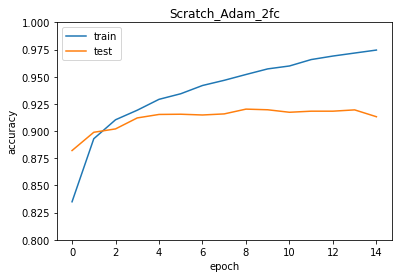

10000/10000 [==============================] - 1s     
----
[0.24566872977614404, 0.91779999999999995]

 Test accuracy: 0.9178


In [121]:
plot_learning_curve(history,'Scratch_Adam_2fc')
test_accuracy('saved_models/scratch.2fc.adam.hdf5')

Apparently, even only use 2 convolutional layers, the model still achieve a tiny bit better result than both lenet and simpler vggnet.